In [1]:
import tensorflow as tf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


class PINNSolver:
    def __init__(self, model=None, is_pinn=True, *args, **kwargs):
        self.model = model

        # Initialize history of losses and global iteration counter
        self.current_loss = 0
        self.hist = []
        self.iter = 0
        self.hello_pinn_info = 'Hello PINN!'
        self.is_pinn = is_pinn
        self.loss1 = None
        self.loss2 = None

    def get_residual_loss(self):
        return self.residual_function()

    def objective_function(self, x, y):

        # Add neural network loss
        y_pred = self.model(x)

        # Initialize loss
        self.loss1 = tf.reduce_mean(tf.square(y - y_pred))

        if self.is_pinn:
            # Compute residuals
            residual_loss = self.get_residual_loss()
            res_loss_mse = tf.reduce_mean(tf.square(residual_loss))
            self.loss2 = res_loss_mse
            # tf.print(self.loss2)
            # loss = self.loss2

            # loss = self.loss1 + self.loss2
            loss = self.loss2

        else:
            loss = self.loss1

        return loss

    def get_grad(self, x, y):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.objective_function(x, y)

        loss_grad = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, loss_grad

    def residual_function(self, *args):
        """Residual of the PDE"""
        self.hello_pinn_info = "Goodbye PINN!"
        return 0

    def solve_with_tf_optimizer(self, optimizer=tf.keras.optimizers.Adam(), x=None, y=None, n_step=1001):
        """This method performs a gradient descent type optimization."""
        best = 1e20
        wait = 0
        patience = 200

        @tf.function
        def train_step():
            loss, loss_grad = self.get_grad(x, y)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(loss_grad, self.model.trainable_variables))
            return loss

        for i in range(n_step):
            loss = train_step().numpy()

            self.current_loss = loss
            self.callback()

            wait += 1
            if loss < best:
                best = loss
                wait = 0
            if wait >= patience:
                break

    def solve_with_scipy_optimizer(self, x, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0] * vs[1]
                    new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx + vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                ''' Error should raise if vs > 2: not implemented yet! '''

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(weights):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in model
            set_weight_tensor(weights)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, loss_grad = self.get_grad(x, u)

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in loss_grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat, dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat

        return minimize(fun=get_loss_and_grad,
                        x0=x0,
                        jac=True,
                        method=method,
                        callback=self.callback,
                        options={'maxiter': 5,
                                 'maxfun': 5000000,
                                 'maxcor': 5,
                                 'maxls': 5,
                                 'ftol': 1.0 * np.finfo(float).eps},
                        **kwargs)

    def callback(self, xr=None):
        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter += 1

In [55]:
#from PINN.pinn_solver import PINNSolver
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time
import pandas as pd

from PIL import Image


# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback


DTYPE = 'float32'


class SPINN(PINNSolver):
    def __init__(self, x_r, u_r, y_r, s1, s2, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.K11 = 2.0
        self.K12 = 0
        self.K21 = 0
        self.K22 = 1.0
        self.tau11 = 5.0
        self.tau12 = 5.0 
        self.tau21 = 5.0
        self.tau22 = 5.0
        self.reswA=1.0
        self.reswB=1.0
        self.x_r = x_r
        self.u = u_r
        self.y_r = y_r
        self.s1 = s1
        self.s2 = s2
        self.dt = 1
        
        self.files = []
        
    @tf.function
    def get_residual_loss(self):
 
        y = self.model(self.x_r)
            
        return self.residual_function(self.u, y)

    def residual_function(self, u, y_nn):
        """Residual of the ODE"""
        y = (y_nn+1)/2 * (self.s2.- self.s2.data_min_)+self.s2.data_min_
        
        

        y_t1 = (y[1:,0]-y[:-1,0]) / self.dt
        yn1 = y[0:-1,0]
        un1 = u[0:-6,0]
        
        y_t2 = (y[1:,1]-y[:-1,1]) / self.dt
        yn2 = y[0:-1,1]
        un2 = u[0:-6,1]
        #tf.print(len(y_t1),len(yn1))
        resA = self.tau11 * y_t1 +yn1 - self.K11 * un1
        resB = self.tau22 * y_t2 +yn2 - self.K22 * un2
        
        
        
        res=resA*self.reswA+resB*self.reswB

        return 1*res

    def callback(self, *args):
        
        path = "figures_for_gif/"

        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss)
                  )
        
        # making animation
#         y_meas = self.y_r # Data Range for Animation
#         y_nn = self.model(self.x_r)
#         y_meas = self.s2.inverse_transform(y_meas)
#         y_nn = self.s2.inverse_transform(y_nn)


#         plt.figure(0, figsize=(12,3))
# #         plt.subplot(2,1,1)
#         plt.plot(y_nn,'r-',label='LSTM')
#         plt.plot(y_meas,'b--',label='Measured')
#         plt.ylim([0,3.5])
#         plt.xlim([0,len(y_nn)])
#         plt.title('LSTM-Onestep model Validation',fontsize=15)
#         plt.ylabel("T1", fontsize=13)
#         plt.legend(loc=4,fontsize=13)
#         plt.text(10,2.5,"Training step: %i"%(self.iter+1),fontsize="xx-large",color="k")
#         plt.savefig(path + "animation{}.png".format(self.iter), bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=100, facecolor="white")
#         plt.clf()
#         plt.close()

#         self.files.append(path + "animation{}.png".format(self.iter))
            
        self.hist.append(self.current_loss)
        self.iter += 1

In [56]:
# for creating animation
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [57]:
# Load Data
data1 = pd.read_pickle('MIMO_open_loop_data_start.pkl') # for LOSS 1 (NN Training)

data2 = pd.read_pickle('MIMO_open_loop_data_6000.pkl') # for Loss 2 (PINN) 
#data3 = pd.concat([data1[0], data2[0]], ignore_index=True) # for validation 

In [58]:
data1 = np.transpose(data1)
data2 = np.transpose(data2)


In [78]:

data1=pd.DataFrame(data1)
data1.columns=['u1','u2','y1','y2']
data2 = pd.DataFrame(data2)
data2.columns=['u1','u2','y1','y2']



data3 = pd.concat([data1, data2],ignore_index=True) # for validation 
print(data3)

            u1        u2        y1        y2
0     0.000000  0.000000  2.911058  1.009909
1     0.000000  0.000000  2.425882  0.841590
2     0.000000  0.000000  2.021568  0.701325
3     0.000000  0.000000  1.684640  0.584438
4     0.000000  0.000000  1.403867  0.487032
...        ...       ...       ...       ...
6195  0.914052  2.713354  1.827442  2.711897
6196  0.914052  2.713354  1.827552  2.712140
6197  0.914052  2.713354  1.827644  2.712342
6198  0.914052  2.713354  1.827721  2.712511
6199  0.914052  2.713354  1.827784  2.712651

[6200 rows x 4 columns]


In [60]:
path ="figs_result/"

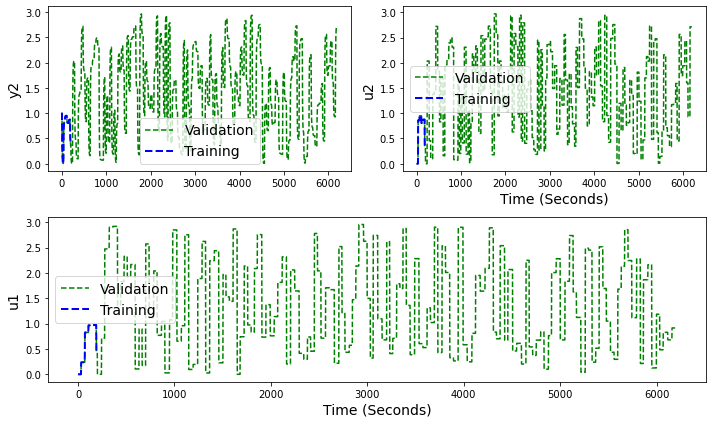

In [61]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(data3["y1"], 'g--',  label='Validation')
plt.plot(data1["y1"], 'b--', linewidth=2, label='Training')

plt.ylabel("y1",fontsize=14)
plt.legend(fontsize=14)

plt.subplot(212)
plt.plot(data3["u1"], 'g--',label='Validation')
plt.plot(data1["u1"], 'b--',linewidth=2,label='Training')
plt.ylabel("u1",fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(221)
plt.plot(data3["y2"], 'g--',  label='Validation')
plt.plot(data1["y2"], 'b--', linewidth=2, label='Training')

plt.ylabel("y2",fontsize=14)
plt.legend(fontsize=14)

plt.subplot(222)
plt.plot(data3["u2"], 'g--',label='Validation')
plt.plot(data1["u2"], 'b--',linewidth=2,label='Training')
plt.ylabel("u2",fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(fontsize=14)



plt.tight_layout()

#plt.savefig(path + 'FOPDT Data for PINN training.eps', format='eps')
#plt.savefig(path + 'FOPDT Data for PINN training.png', format='png')

plt.show()

In [62]:
# Data scaling

# # Scale features
# s1 = MinMaxScaler(feature_range=(-1,1))
# s1.data_max_ = np.array([6,6,6,6])
# s1.data_min_ = np.array([0,0,0,0])
# s1.min_ = np.array([-1,-1,-1,-1])
# s1.max_ = np.array([1,1,1,1])
# s1.data_range_ = np.array([6,6,6,6])
# s1.scale_ = np.array([1,1,1,1])

# s2 = MinMaxScaler(feature_range=(-1,1))
# s2.data_max_ = np.array([6,6])
# s2.data_min_ = np.array([0,0])
# s2.data_range_ = np.array([6,6])
# s2.min_ = np.array([-1,-1])
# s2.max_ = np.array([1,1])
# s2.scale_ = np.array([1,1])

# # Execute scaling
# Xs1 = s1.transform(data1[['u1','u2','y1','y2']].to_numpy())
# Ys1 = s2.transform(data1[['y1','y2']].to_numpy())


# Xs2 = s1.transform(data3[['u1','u2','y1','y2']].to_numpy())
# Ys2 = s2.transform(data3[['y1','y2']].to_numpy())



# # window = 5

# # # Save model parameters
# # model_params = dict()
# # model_params['Xscale'] = s1
# # model_params['yscale'] = s2
# # model_params['window'] = window

# # dump(model_params, open('model_param.pkl', 'wb'))
# # print(Xs1a)

# plt.plot(Xs2)


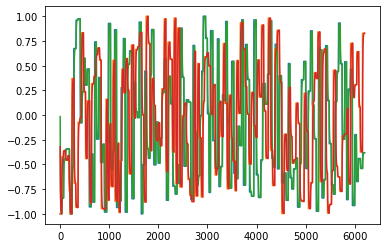

In [63]:
s1 = MinMaxScaler(feature_range=(-1,1))
# s1.data_max_ = np.array([6,6,6,6])
# s1.data_min_ = np.array([0,0,0,0])
# s1.min_ = np.array([-1,-1,-1,-1])
# s1.max_ = np.array([1,1])
# s1.data_range_ = np.([2,2])
# s1.scale_ = np.array([2/3,2/3,2/3,2/3]) # Maunaly calcualated

s2 = MinMaxScaler(feature_range=(-1,1))
# s2.data_max_ = np.array([6,6])
# s2.data_min_ = np.array([0,0])
# #s2.data_range_ = np.array([2])
# s2.min_ = np.array([-1,-1])
# #s2.max_ = np.array([1])
# s2.scale_ = np.array([2/3,2/3])

# Execute scaling
Xs1 = s1.fit_transform(data1[['u1','u2','y1','y2']].to_numpy())
Ys1 = s2.fit_transform(data1[['y1','y2']].to_numpy())

Xs2 = s1.fit_transform(data3[['u1','u2','y1','y2']].to_numpy())
Ys2 = s2.fit_transform(data3[['y1','y2']].to_numpy())

window = 5

# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window

dump(model_params, open('model_param.pkl', 'wb'))
plt.plot(Xs2)

In [64]:
s1.data_max_

array([2.95481537, 2.96822446, 5.90941421, 2.96690614])

In [65]:
# Data Snap shots for training data

X_train = []
Y_train = []
for i in range(window,len(Xs1)):
    X_train.append(Xs1[i-window:i,:])
    Y_train.append(Ys1[i])

# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [66]:
# Data Snap shots for validation data
X_val = []
Y_val = []
for i in range(window,len(Xs2)):
    X_val.append(Xs2[i-window:i,:])
    Y_val.append(Ys2[i])

# Reshape data to format accepted by LSTM
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [67]:
#LSTM model 1 for PINN Off mode
model_lstm1 = Sequential()

model_lstm1.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm1.add(Dropout(0.2))
model_lstm1.add(LSTM(units=100, return_sequences=True))
model_lstm1.add(Dropout(0.2))
model_lstm1.add(LSTM(units=100))
model_lstm1.add(Dropout(0.2))
model_lstm1.add(Dense(units=Y_train.shape[1])) #units = number of outputs
# model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
            #   metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)



# LSTM model 2 for PINN On mode
model_lstm2 = Sequential()

model_lstm2.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(LSTM(units=100, return_sequences=True))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(LSTM(units=100))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(Dense(units=Y_train.shape[1])) #units = number of outputs
# model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
            #   metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)


# input data ("u") for loss2 (pinn)
x_r = X_val # Scaled Snapshot of X to evaluating NN model

u_r = np.array(data3)
u_r = tf.convert_to_tensor(u_r, DTYPE)

y_r = Y_val # Scaled Snapshot of Y

solver1 = SPINN(model=model_lstm1, x_r=x_r,u_r=u_r, y_r=y_r, s1=s1, s2=s2, is_pinn=False)
solver2 = SPINN(model=model_lstm2, x_r=x_r,u_r=u_r, y_r=y_r, s1=s1, s2=s2, is_pinn=True)
# # Choose step sizes aka learning rate
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 5000], [1e-3, 1e-4, 1e-5])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam()

X_train = tf.convert_to_tensor(X_train, DTYPE)
Y_train = tf.convert_to_tensor(Y_train, DTYPE)


In [68]:
u_r

<tf.Tensor: shape=(6200, 4), dtype=float32, numpy=
array([[0.        , 0.        , 2.9110582 , 1.0099086 ],
       [0.        , 0.        , 2.4258819 , 0.84159046],
       [0.        , 0.        , 2.021568  , 0.70132536],
       ...,
       [0.9140518 , 2.7133539 , 1.8276441 , 2.712342  ],
       [0.9140518 , 2.7133539 , 1.8277206 , 2.7125108 ],
       [0.9140518 , 2.7133539 , 1.8277845 , 2.7126513 ]], dtype=float32)>

In [34]:
# PINN Off case
solver1.is_pinn = False
solver1.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=300)

It 00000: loss = 3.76745105e-01
It 00010: loss = 7.39981011e-02
It 00020: loss = 2.67660841e-02
It 00030: loss = 1.08986087e-02
It 00040: loss = 6.83498010e-03
It 00050: loss = 5.66422334e-03
It 00060: loss = 4.66705998e-03
It 00070: loss = 4.19787457e-03
It 00080: loss = 3.95792304e-03
It 00090: loss = 3.84143041e-03
It 00100: loss = 3.73712322e-03
It 00110: loss = 3.65890306e-03
It 00120: loss = 3.58004472e-03
It 00130: loss = 3.50232515e-03
It 00140: loss = 3.42397136e-03
It 00150: loss = 3.34470649e-03
It 00160: loss = 3.26426956e-03
It 00170: loss = 3.18233692e-03
It 00180: loss = 3.09858937e-03
It 00190: loss = 3.01268534e-03
It 00200: loss = 2.92426255e-03
It 00210: loss = 2.83293542e-03
It 00220: loss = 2.73831957e-03
It 00230: loss = 2.64006876e-03
It 00240: loss = 2.53792806e-03
It 00250: loss = 2.43183807e-03
It 00260: loss = 2.32204958e-03
It 00270: loss = 2.20924011e-03
It 00280: loss = 2.09457055e-03
It 00290: loss = 1.97966746e-03


In [52]:
# save_gif_PIL("pinn_off.gif", solver1.files, fps=50, loop=0)  

In [53]:
#%% Save LSTM model file
solver1.model.save('PINN_FOPDT_onestep_LSTM_pinn_off.h5')

In [69]:
# #PINN On case
solver2.is_pinn = True
solver2.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=300)

solver2.solve_with_scipy_optimizer(X_train, Y_train, method='L-BFGS-B')

It 00000: loss = 4.41880560e+00
It 00010: loss = 1.40639603e+00
It 00020: loss = 7.89572716e-01
It 00030: loss = 2.76347071e-01
It 00040: loss = 2.28829309e-02
It 00050: loss = 4.01007049e-02
It 00060: loss = 2.64653414e-02
It 00070: loss = 2.23021414e-02
It 00080: loss = 2.03288030e-02
It 00090: loss = 1.87817160e-02
It 00100: loss = 1.85796618e-02
It 00110: loss = 1.82671733e-02
It 00120: loss = 1.80293340e-02
It 00130: loss = 1.78139340e-02
It 00140: loss = 1.75955594e-02
It 00150: loss = 1.73755717e-02
It 00160: loss = 1.71515420e-02
It 00170: loss = 1.69191174e-02
It 00180: loss = 1.66760106e-02
It 00190: loss = 1.64216775e-02
It 00200: loss = 1.61595847e-02
It 00210: loss = 1.58995539e-02
It 00220: loss = 1.56539157e-02
It 00230: loss = 1.54277394e-02
It 00240: loss = 1.52141703e-02
It 00250: loss = 1.50001608e-02
It 00260: loss = 1.47742080e-02
It 00270: loss = 1.45289460e-02
It 00280: loss = 1.42602352e-02
It 00290: loss = 1.39665185e-02
It 00300: loss = 1.36479028e-02


      fun: 0.0136341517791152
 hess_inv: <203002x203002 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.62410559e-06, -7.40365431e-06, -6.06088834e-05, ...,
       -2.10639671e-04, -1.08690793e-03, -5.45670744e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 7
      nit: 5
     njev: 7
   status: 1
  success: False
        x: array([ 8.00143111e-05, -3.42634486e-02,  3.63151755e-03, ...,
       -6.05097108e-02, -2.99726967e-03, -2.96095440e-03])

In [42]:
# save_gif_PIL("pinn_on.gif", solver2.files, fps=50, loop=0)  

In [77]:
print(data3)

[[0.         0.         2.91105817 1.00990852]
 [0.         0.         2.42588181 0.84159044]
 [0.         0.         2.02156818 0.70132537]
 ...
 [0.91405179 2.71335394 1.8276441  2.71234213]
 [0.91405179 2.71335394 1.82772068 2.71251076]
 [0.91405179 2.71335394 1.8277845  2.71265129]]


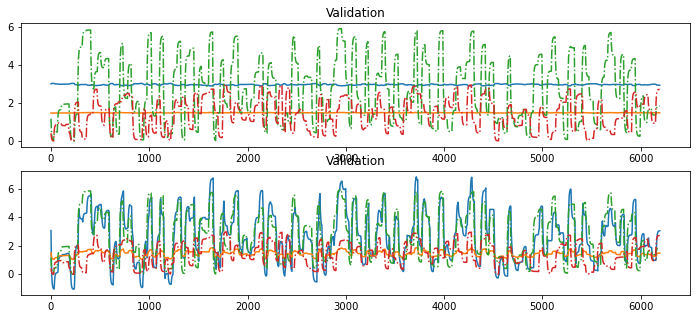

In [79]:
# Model evaluation with input datas (PINN off model)
ynn_off = solver1.model(X_val)
ynn_off = s2.inverse_transform(ynn_off)

# Model evaluation with input datas (PINN on model)
ynn_on = solver2.model(X_val)
ynn_on = s2.inverse_transform(ynn_on)

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.gca().set_title('Validation')
plt.plot(ynn_off)
plt.plot(data3["y1"].to_numpy()[window:], '-.')
plt.plot(data3["y2"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_off.shape[0]+window+window:], '-.')

plt.subplot(2,1,2)
plt.gca().set_title('Validation')
plt.plot(ynn_on)
plt.plot(data3["y1"].to_numpy()[window:], '-.')
plt.plot(data3["y2"].to_numpy()[window:], '-.')
# plt.plot(validation["y"].to_numpy()[ynn_train_on.shape[0]+window+window:], '-.')


plt.show()

In [44]:
Xsq = Xs2.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys2.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):] = solver1.model.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):]

Ytu_nn_off = s2.inverse_transform(Ysq)

In [45]:
Xsq = Xs2.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys2.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):] = solver2.model.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):]

Ytu_nn_on = s2.inverse_transform(Ysq)

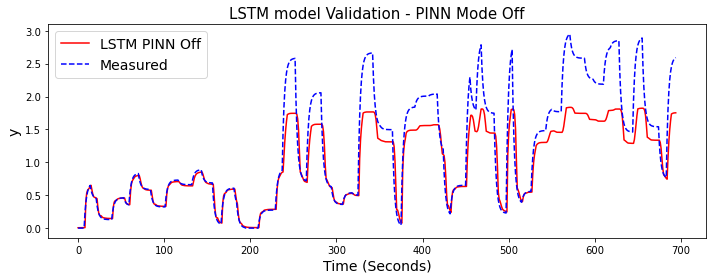

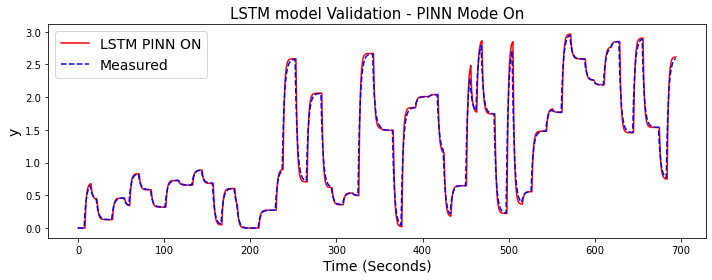

In [47]:
Ym_val = data3[['y']].to_numpy()[window:]

plt.figure(0, figsize=(10,4))
# plt.subplot(2,1,1)
plt.plot(Ytu_nn_off[window:],'r-',label='LSTM PINN Off')
plt.plot(Ym_val,'b--',label='Measured')
plt.title('LSTM model Validation - PINN Mode Off',fontsize=15)
plt.ylabel("y", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tight_layout()

#plt.savefig(path + 'FOPDT_PINN_Training_result_PINN_Off.eps', format='eps')
#plt.savefig(path + 'FOPDT_PINN_Training_result_PINN_Off.png', format='png')


plt.figure(1, figsize=(10,4))
# plt.subplot(2,1,2)
plt.plot(Ytu_nn_on[window:],'r-',label='LSTM PINN ON')
plt.plot(Ym_val,'b--',label='Measured')
plt.title('LSTM model Validation - PINN Mode On',fontsize=15)
plt.ylabel("y", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.tight_layout()

#plt.savefig(path + 'FOPDT_PINN_Training_result_PINN_On.eps', format='eps')
#plt.savefig(path + 'FOPDT_PINN_Training_result_PINN_On.png', format='png')

plt.show()